<a href="https://colab.research.google.com/github/gokulspritle/electronautoupdate/blob/master/OCR_for_l%26T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title Usual Imports
import numpy as np
import torch 
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time, random
import os, cv2,keras
from torch.utils.data import Dataset, DataLoader
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

from torchvision import transforms
print(torch.__version__)
from torch.autograd import Variable
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
#!pip install torchsummary --quiet
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

1.9.0+cu102


In [3]:
# utility functions

def image_preprocess(file_path, img_size=224):#input_size):
  image = cv2.imread(file_path)
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (img_size, img_size))
  image = image.astype(np.float32)
  image /= 255.
  # print("Shape {} and Type {} and Data-Type {}".format(image.shape, type(image), image.dtype))
  image = np.array(image)
  image = torch.from_numpy(image)
  #plt.imshow(image)
  #plt.show()
  return image

# **Exploratory Analysis**

In [4]:
#  !unzip "/content/drive/MyDrive/L&T/move.zip" -d "/content/drive/MyDrive/L&T/"

In [5]:
source_path = "/content/drive/MyDrive/Ocr_lnT/chromePlateDataset"
artifacts_path = '/content/drive/MyDrive/Ocr_lnT/model_artifacts_lt'
file_path = []
labels = []

for label in os.listdir(source_path):
  for fp in os.listdir(os.path.join(source_path, label)):
    full_path = str(os.path.join(os.path.join(source_path, label), fp))
    file_path.append(full_path)
    labels.append(str(label))
assert len(file_path) == len(labels)

df = pd.DataFrame(list(zip(file_path, labels)), columns =['file_path', 'labels']) 
print("Shape of dataframe",df.shape)
df.head();df.tail()

Shape of dataframe (8277, 2)


,file_path,labels
8272,/content/drive/MyDrive/Ocr_lnT/chromePlateData...,3
8273,/content/drive/MyDrive/Ocr_lnT/chromePlateData...,3
8274,/content/drive/MyDrive/Ocr_lnT/chromePlateData...,3
8275,/content/drive/MyDrive/Ocr_lnT/chromePlateData...,3
8276,/content/drive/MyDrive/Ocr_lnT/chromePlateData...,3


In [39]:
8277*(10/100)

827.7

In [6]:
!nvidia-smi

df.labels.unique()

Thu Jul 29 10:29:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

array(['4', '6', '7', '5', '8', '9', '1', '10', '11', '12', '13', '14',
       '15', '16', '18', '19', '2', '20', '22', '23', '3'], dtype=object)

In [7]:
# Mapper

mapper_dict = {'1':0, '2':1, '3':2, '4':3, '5':4, '6':5, '7':6, '8':7, '9':8, '10':9, 
               '11':10, '12':11, '13':12, '14':13, '15':14, '16':15, '18':16, '19':17, '20':18, '22':19, '23':20}

df['labels'] = df['labels'].map(mapper_dict, na_action='ignore')
from pprint import pprint
pprint(df.head(5))

                                           file_path  labels
0  /content/drive/MyDrive/Ocr_lnT/chromePlateData...       3
1  /content/drive/MyDrive/Ocr_lnT/chromePlateData...       3
2  /content/drive/MyDrive/Ocr_lnT/chromePlateData...       3
3  /content/drive/MyDrive/Ocr_lnT/chromePlateData...       3
4  /content/drive/MyDrive/Ocr_lnT/chromePlateData...       3


/content/drive/MyDrive/Ocr_lnT/chromePlateDataset/4/L_T_CPLL1_105.jpg
/content/drive/MyDrive/Ocr_lnT/chromePlateDataset/3/9d2c65.png 

label 3 - Total Count 279 

label 5 - Total Count 525 

label 6 - Total Count 713 

label 4 - Total Count 598 

label 7 - Total Count 386 

label 8 - Total Count 314 

label 0 - Total Count 556 

label 9 - Total Count 349 

label 10 - Total Count 374 

label 11 - Total Count 337 

label 12 - Total Count 150 

label 13 - Total Count 114 

label 14 - Total Count 188 

label 15 - Total Count 479 

label 16 - Total Count 644 

label 17 - Total Count 146 

label 1 - Total Count 494 

label 18 - Total Count 215 

label 19 - Total Count 293 

label 20 - Total Count 198 

label 2 - Total Count 925 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


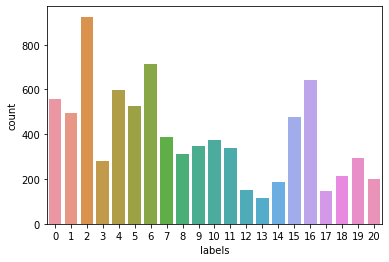

In [8]:
print(df['file_path'][0])
print(df['file_path'][df.shape[0]-1],"\n")

for i in df['labels'].unique():
    print("label {} - Total Count {}".format(i,df.labels[df.labels==i].count()),"\n")

import seaborn as sns
sns.countplot(df['labels'])

# Assigning folds (Train (90%) & Valid (10%))

In [9]:
fold = ['train']*(int(len(df)*0.9)) + ['valid']*(len(df) - int(len(df)*0.9))
random.shuffle(fold)
df['fold'] = fold
print(df.shape);df.to_csv('/content/drive/MyDrive/L&T/Training.csv')
df.head()

(8277, 3)


,file_path,labels,fold
0,/content/drive/MyDrive/Ocr_lnT/chromePlateData...,3,valid
1,/content/drive/MyDrive/Ocr_lnT/chromePlateData...,3,valid
2,/content/drive/MyDrive/Ocr_lnT/chromePlateData...,3,train
3,/content/drive/MyDrive/Ocr_lnT/chromePlateData...,3,train
4,/content/drive/MyDrive/Ocr_lnT/chromePlateData...,3,train


# Fact check on how many train and test split exists for each class.

In [10]:
for i in df['labels'].unique():
    train = valid = 0
    train = df[(df['labels'] == i) & (df['fold'] =="train")].shape[0]
    valid = df[(df['labels'] == i) & (df['fold'] =="valid")].shape[0]
    print("For class {}, total number of training samples is {} and testing samples is {}".format(i, train, valid))


For class 3, total number of training samples is 260 and testing samples is 19
For class 5, total number of training samples is 480 and testing samples is 45
For class 6, total number of training samples is 651 and testing samples is 62
For class 4, total number of training samples is 537 and testing samples is 61
For class 7, total number of training samples is 342 and testing samples is 44
For class 8, total number of training samples is 275 and testing samples is 39
For class 0, total number of training samples is 492 and testing samples is 64
For class 9, total number of training samples is 318 and testing samples is 31
For class 10, total number of training samples is 335 and testing samples is 39
For class 11, total number of training samples is 313 and testing samples is 24
For class 12, total number of training samples is 136 and testing samples is 14
For class 13, total number of training samples is 101 and testing samples is 13
For class 14, total number of training samples i

# End of Exploratory analysis and dataframe preprocessing

# Image preprocessing starts

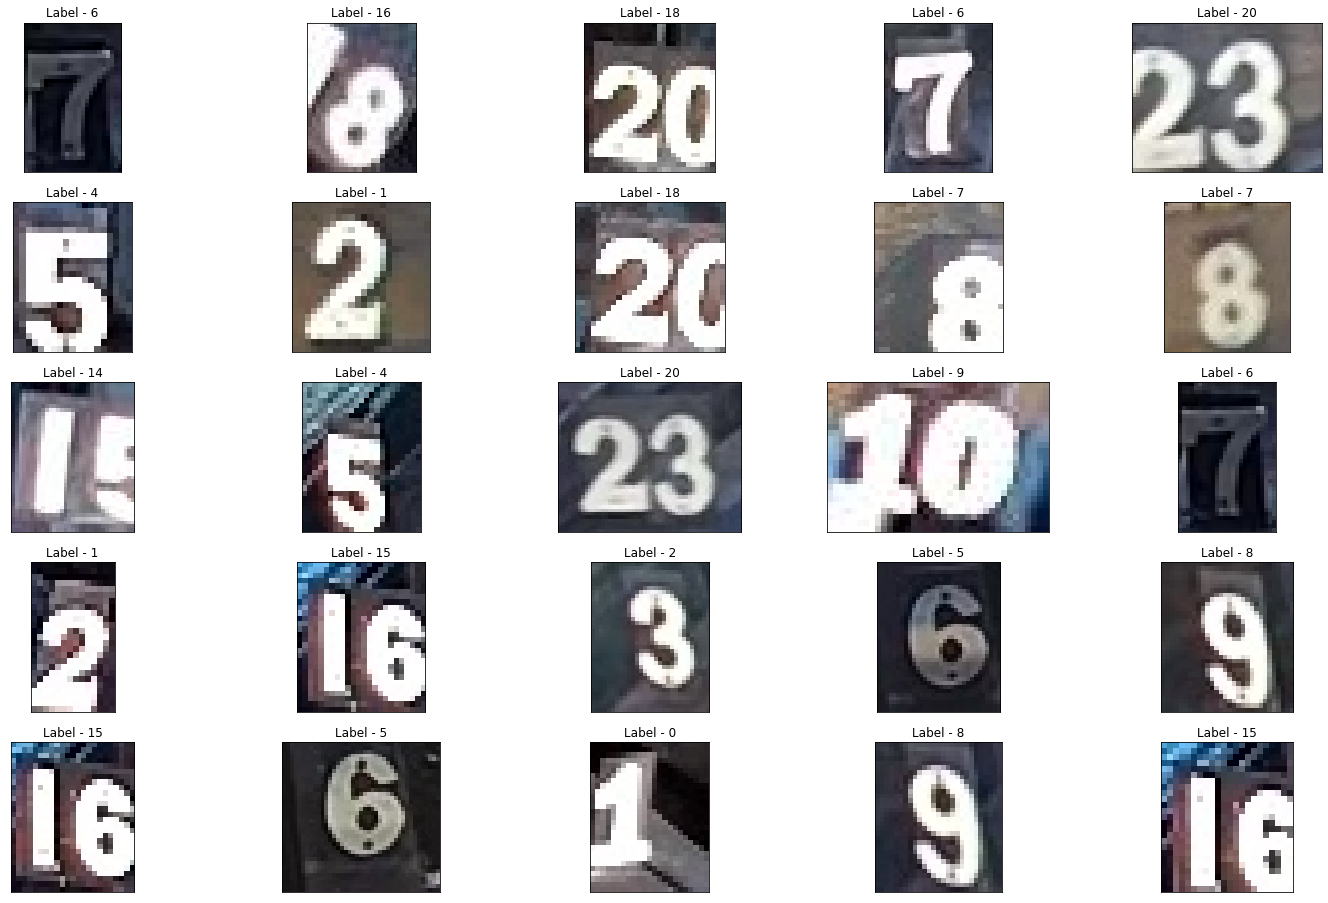

In [11]:
NUM_SAMP=5
fig = plt.figure(figsize=(25, 16))
IMG_SIZE = 256
for jj in range(5):
    for i, (idx, row) in enumerate(df.sample(NUM_SAMP,random_state=123+jj).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, jj * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path= row['file_path']
        label = row['labels'] 
        image = cv2.imread(path)
        plt.imshow(image)
        ax.set_title('Label - %s' % (label) )

# Pytorch Model Building

# Building the model as a classifier (n output classes) 

In [12]:
import os, sys, subprocess
try:
    from efficientnet_pytorch import EfficientNet
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'efficientnet_pytorch'])
    from efficientnet_pytorch import EfficientNet
    
classifier = True # input as False makes the model regressor.

# Flag for feature extracting. When False, we finetune the whole model,
feature_extract = False

# Number of classes in the dataset
num_classes = len(df['labels'].unique()) # Classifier
criterion =  nn.CrossEntropyLoss()  

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        print("Downloading Resnet18 model")
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.avgpool = nn.AdaptiveMaxPool2d(output_size=(1, 1))
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        print("Downloading Alexnet model")
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        print("Downloading VGG11_bn model")
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        print("Downloading Squeezenet model")
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        print("Downloading Densenet model")
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        print("Downloading Inception v3 model")
        model_ft = models.inception_v3(pretrained=use_pretrained, aux_logits=False)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        #num_ftrs = model_ft.AuxLogits.fc.in_features
        #model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name == "mobilenet":
        """Mobilenet
        """
        print("Downloading mobilenet model")
        model_ft = models.mobilenet_v2(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "efficientnet-b0":
        """ efficientnet https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b0')
        model_ft.set_swish(memory_efficient=False)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft._fc.in_features
        # model_ft._avg_pooling = nn.AdaptiveMaxPool2d(output_size=(1, 1))
        model_ft._fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "efficientnet-b1":
        """ efficientnet
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b1')
        model_ft.set_swish(memory_efficient=False)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft._fc.in_features
        model_ft._avg_pooling = nn.AdaptiveMaxPool2d(output_size=(1, 1))
        model_ft._fc = nn.Linear(num_ftrs, num_classes)
        input_size = 240
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [13]:
num_classes = len(df['labels'].unique()) # Classifier
print(num_classes)
df['labels'].unique()

21


array([ 3,  5,  6,  4,  7,  8,  0,  9, 10, 11, 12, 13, 14, 15, 16, 17,  1,
       18, 19, 20,  2])

# Model Selection

In [14]:
# Initialize the model for this run
model_name = "mobilenet" # Models to choose ["resnet", "vgg", "squeezenet", "densenet", "inception", "mobilenet", "efficientnet-b0", "efficientnet-b1"]
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)
print()
print("Input image size format",(input_size,input_size))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, mome

In [15]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model_ft = model_ft.to(device)

if model_name != "densenet":
  summary(model_ft, (3, input_size, input_size))
  pass


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [16]:
sample_input = torch.randn(2,3,input_size,input_size)
sample_input = sample_input.to(device)
print("Shape {} and Type {} and Data-Type {}".format(sample_input.shape, type(sample_input), sample_input.dtype))
out = model_ft(sample_input)
out

Shape torch.Size([2, 3, 224, 224]) and Type <class 'torch.Tensor'> and Data-Type torch.float32


tensor([[ 0.4633,  0.1165, -0.0863, -0.2544, -0.2589, -0.0568,  0.1662,  0.0249,
         -0.2938, -0.4363,  0.1609, -0.1825, -0.4037, -0.4233, -0.1579,  0.1151,
          0.3441,  0.0102, -0.4566,  0.0284,  0.3344],
        [-0.1879,  0.3895,  0.0625, -0.1470,  0.1232,  0.0618,  0.5843, -0.1430,
          0.2816,  0.1866, -0.4758,  0.0636,  0.0165,  0.4798,  0.3400,  0.0412,
          0.1785,  0.1191,  0.0726, -0.1957,  0.4246]], device='cuda:0',
       grad_fn=<AddmmBackward>)

# Hyper-Parameters

In [17]:
BATCH_SIZE =  128 # Desired batch size
img_size = input_size # This sets the input image size based on the model's you choose
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Running on",device)
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


learning_rate=0.001

#optimizer = optim.Adam(params_to_update, lr=learning_rate)
optimizer = optim.SGD(params_to_update, lr=learning_rate , momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.85, patience=2, verbose=True)

Running on cuda:0
Params to learn:
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.conv.0.0.weight
	 features.1.conv.0.1.weight
	 features.1.conv.0.1.bias
	 features.1.conv.1.weight
	 features.1.conv.2.weight
	 features.1.conv.2.bias
	 features.2.conv.0.0.weight
	 features.2.conv.0.1.weight
	 features.2.conv.0.1.bias
	 features.2.conv.1.0.weight
	 features.2.conv.1.1.weight
	 features.2.conv.1.1.bias
	 features.2.conv.2.weight
	 features.2.conv.3.weight
	 features.2.conv.3.bias
	 features.3.conv.0.0.weight
	 features.3.conv.0.1.weight
	 features.3.conv.0.1.bias
	 features.3.conv.1.0.weight
	 features.3.conv.1.1.weight
	 features.3.conv.1.1.bias
	 features.3.conv.2.weight
	 features.3.conv.3.weight
	 features.3.conv.3.bias
	 features.4.conv.0.0.weight
	 features.4.conv.0.1.weight
	 features.4.conv.0.1.bias
	 features.4.conv.1.0.weight
	 features.4.conv.1.1.weight
	 features.4.conv.1.1.bias
	 features.4.conv.2.weight
	 features.4.conv.3.weight
	 features.4.co

# DATASET and DATALOADERS for pytorch

In [18]:
def image_preprocess(file_path, img_size=input_size):
  image = cv2.imread(file_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (img_size, img_size))
  image = image.astype(np.float32)
  image /= 255.
  # print("Shape {} and Type {} and Data-Type {}".format(image.shape, type(image), image.dtype))
  image = np.array(image)
  image = torch.from_numpy(image)
  #plt.imshow(image)
  #plt.show()
  return image

In [19]:

class HPAviation_Dataset(Dataset):
    # Constructor
    def __init__(self, df, fold , img_size, transform=None, sample=0):
        # Image directory
        self.transform = transform
        self.img_size = img_size
        self.fold = fold
        self.sub_df = df[df['fold'] == self.fold]
        self.sample = sample
        if self.sample > 0:
            self.sub_df = self.sub_df.sample(self.sample, random_state=42) # sample

    # Get the length
    def __len__(self):
        return len(self.sub_df)
    
    # Getter
    def __getitem__(self, idx):
        path = self.sub_df.index[idx]
        #print(path)
        image = image_preprocess(path, img_size)
        label = np.array(self.sub_df.labels[idx])
        label = label.astype(np.uint8)
        label = torch.from_numpy(label)
        #print(label)
        return image, label

# Batch size
df_to_model = df
df_to_model = df_to_model.set_index('file_path')

SAMPLE = 0 # Increase the sample size if you want to train only on a specific number of samples, otherwise to train on entire datset, set sample = 0

transformed_datasets = {}
transformed_datasets['train'] = HPAviation_Dataset(df = df_to_model, fold="train" ,img_size = img_size, sample=SAMPLE)
transformed_datasets['valid'] = HPAviation_Dataset(df = df_to_model, fold="valid" ,img_size = img_size, sample=SAMPLE)
 
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(transformed_datasets['train'],batch_size=BATCH_SIZE,shuffle=True ,num_workers=2)
dataloaders['valid'] = torch.utils.data.DataLoader(transformed_datasets['valid'],batch_size=BATCH_SIZE,shuffle=True ,num_workers=2)  
print()
print("Total images in the training loop is {}, divided by a batchsize of {} , that is {} total sets".format(len(transformed_datasets['train']), BATCH_SIZE, len(dataloaders['train'])))
print("Total images in the testing loop is {}, divided by a batchsize of {} , that is {} total sets".format(len(transformed_datasets['valid']), BATCH_SIZE, len(dataloaders['valid'])))



Total images in the training loop is 7449, divided by a batchsize of 128 , that is 59 total sets
Total images in the testing loop is 828, divided by a batchsize of 128 , that is 7 total sets


# Excerpts from the training samples

tensor([10,  2, 20, 20,  0,  2,  7,  7, 10, 16,  5,  4, 16, 16,  4,  6, 14,  5,
        16, 16, 16,  8,  6,  9,  5,  6, 16,  7,  2,  6,  0,  0,  7, 15,  2, 11,
         6, 10, 18, 15,  0, 19,  6, 20, 10,  2,  1,  4,  1, 15, 20,  5, 12,  2,
         5,  8, 15,  9,  8,  3,  7, 10,  5, 20,  9,  2, 12, 16, 18,  3,  5, 15,
        17,  3, 16,  3, 16,  1,  5,  7, 14,  2, 16, 17, 15,  4,  5,  2,  7,  8,
         5,  1,  1,  9, 10,  1,  7, 16, 10,  4, 16, 16,  6, 19,  6,  0,  7, 10,
        16,  6, 16,  8,  1, 15,  5,  2,  1,  4,  8,  5,  0, 19,  8,  1, 18, 15,
         2, 12], dtype=torch.uint8) torch.Size([128])


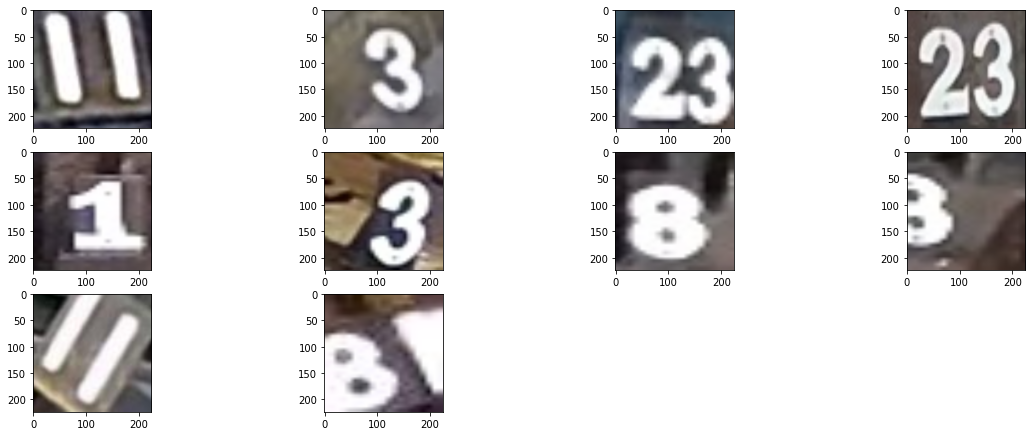

In [20]:
for data in dataloaders['valid']:
    images, labels = data
    images = images.to('cpu')
    print(labels, labels.shape)
    break
    
plt.figure(figsize=(20,10)) 
for i in range(10):
    plt.subplot(4,4, i+1)
    plt.imshow(images[i,:,:,:])

In [21]:
!pip list

Package                       Version
----------------------------- -------------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argon2-cffi                   20.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.2.1
astunparse                    1.6.3
async-generator               1.10
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        3.3.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheCont

# Training Process

In [22]:
#@title Training Loop Codes
from IPython.display import HTML, display
 
class ProgressMonitor(object):
    """
    Custom IPython progress bar for training
    """
    
    tmpl = """
        <p>Loss: {loss:0.4f}   {value} / {length}</p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
    """
 
    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

def checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_valid_loss, model_save_name, artifacts_path):
    print('saving')
    print()
    state = {'model': model,'best_loss': best_loss,'epoch': epoch,'rng_state': torch.get_rng_state(), 'optimizer': optimizer.state_dict(),}
    subfolder_name = model_ft._get_name()
    try:
      torch.save(state, '{}/{}/{}-TS1.pt'.format(artifacts_path, subfolder_name, model_save_name))
      torch.save(model.state_dict(),'{}/{}/{}-statedict-TS1.pt'.format(artifacts_path, subfolder_name, model_save_name))
    except:
      os.mkdir('{}/{}'.format(artifacts_path, subfolder_name))
      torch.save(state, '{}/{}/{}-TS1.pt'.format(artifacts_path, subfolder_name, model_save_name))
      torch.save(model.state_dict(),'{}/{}/{}-statedict-TS1.pt'.format(artifacts_path, subfolder_name, model_save_name))
    
    
def train_new(model,criterion,optimizer,num_epochs,dataloaders,dataset_sizes, model_save_name,artifacts_path, first_epoch=1):
    since = time.time() 
    best_loss = 999999
    best_epoch = -1
    last_train_loss = -1
    plot_train_loss = []
    plot_valid_loss = []
    plot_train_acc = []
    plot_valid_acc = []
 
 
    for epoch in range(first_epoch, first_epoch + num_epochs):
        print()
        print('Epoch', epoch)
        running_loss = 0.0
        valid_loss = 0.0
        training_accuracy = 0
        validation_accuracy = 0
      
        # train phase
        model.train(True)
 
      # create a progress bar
        progress = ProgressMonitor(length=dataset_sizes["train"])
 
        for data in dataloaders["train"]:
            inputs, labels  = data # (Batch_size, width, height, channels)
            batch_size = inputs.shape[0]
            inputs = inputs.permute(0,3,1,2) # Batch_size, channels, width, height
            inputs = inputs.to(device)
            labels = labels.to(device,dtype=torch.long)
            inputs = Variable(inputs)
            labels = Variable(labels)
 
            # clear previous gradient computation
            optimizer.zero_grad()
            outputs = model(inputs) # batch, 2, 240, 240

            loss = criterion(outputs, labels)
 
            loss.backward()
            optimizer.step()
                      
            running_loss += loss.data * batch_size
            training_accuracy += (outputs.argmax(1) == labels).sum().item()
          # update progress bar
            progress.update(batch_size, running_loss)
 
        epoch_loss = running_loss / dataset_sizes["train"]
        
        print('Training Accuracy is {:.2f} and Training loss {:.2f}'.format(training_accuracy / dataset_sizes["train"],epoch_loss.item()))
        print('Correctly predicted {} Training samples out of {}'.format(training_accuracy, dataset_sizes["train"]))
        print()
        plot_train_loss.append(epoch_loss)
        plot_train_acc.append(training_accuracy / dataset_sizes["train"])
 
 
      # validation phase
        model.eval()
      # We don't need gradients for validation, so wrap in 
      # no_grad to save memory
        with torch.no_grad():
            for data in dataloaders["valid"]:
                inputs, labels  = data
                batch_size = inputs.shape[0]
                inputs = inputs.permute(0,3,1,2)
                inputs = inputs.to(device)
                labels = labels.to(device,dtype=torch.long)
                inputs = Variable(inputs)
                labels = Variable(labels)
                
                outputs = model(inputs)
 
            # calculate the loss
                optimizer.zero_grad()
                loss = criterion(outputs, labels)
            
            # update running loss value
                valid_loss += loss.data * batch_size
                validation_accuracy += (outputs.argmax(1) == labels).sum().item()
                    
 
        epoch_valid_loss = valid_loss / dataset_sizes["valid"]
        scheduler.step(epoch_valid_loss)
        print('Validation Accuracy is {:.2f} and Validation loss {:.2f}'.format(validation_accuracy / dataset_sizes["valid"],epoch_valid_loss.item()))
        print('Correctly predicted {} Validation samples out of {}'.format(validation_accuracy, dataset_sizes["valid"]))
        print()
        plot_valid_loss.append(epoch_valid_loss)
        plot_valid_acc.append(validation_accuracy / dataset_sizes["valid"])
          
        if epoch_valid_loss < best_loss:
            best_loss = epoch_valid_loss
            best_epoch = epoch
            checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_valid_loss.item(), model_save_name, artifacts_path)
            PATH = "/content/{}-TS.pt".format(model_save_name)
            torch.save(model, PATH)

        if ((epoch - best_epoch) >= 10):
            print("no improvement in 10 epochs, break")
            break
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
 
    return plot_train_loss, plot_valid_loss, plot_train_acc, plot_valid_acc, model

# Training Loop

In [23]:
%%time
dataset_sizes = {x: len(transformed_datasets[x]) for x in ['train', 'valid']}
epochs = 10
if __name__=="__main__":
    train_losses, valid_losses, train_accuracy, valid_accuracy, model = train_new(model = model_ft ,criterion = criterion,optimizer = optimizer,
                                                                                  num_epochs=epochs,dataloaders = dataloaders,
                                                                                  dataset_sizes = dataset_sizes, model_save_name = model_name, artifacts_path=artifacts_path)


Epoch 1


Training Accuracy is 0.49 and Training loss 2.00
Correctly predicted 3645 Training samples out of 7449

Validation Accuracy is 0.80 and Validation loss 1.06
Correctly predicted 659 Validation samples out of 828

saving


Epoch 2


Training Accuracy is 0.87 and Training loss 0.68
Correctly predicted 6461 Training samples out of 7449

Validation Accuracy is 0.92 and Validation loss 0.41
Correctly predicted 764 Validation samples out of 828

saving


Epoch 3


Training Accuracy is 0.96 and Training loss 0.30
Correctly predicted 7155 Training samples out of 7449

Validation Accuracy is 0.97 and Validation loss 0.26
Correctly predicted 801 Validation samples out of 828

saving


Epoch 4


Training Accuracy is 0.98 and Training loss 0.17
Correctly predicted 7328 Training samples out of 7449

Validation Accuracy is 0.98 and Validation loss 0.14
Correctly predicted 813 Validation samples out of 828

saving


Epoch 5


Training Accuracy is 0.99 and Training loss 0.11
Correctly predicted 7371 Training samples out of 7449

Validation Accuracy is 0.99 and Validation loss 0.11
Correctly predicted 816 Validation samples out of 828

saving


Epoch 6


Training Accuracy is 0.99 and Training loss 0.08
Correctly predicted 7398 Training samples out of 7449

Validation Accuracy is 0.98 and Validation loss 0.09
Correctly predicted 815 Validation samples out of 828

saving


Epoch 7


Training Accuracy is 0.99 and Training loss 0.06
Correctly predicted 7400 Training samples out of 7449

Validation Accuracy is 0.99 and Validation loss 0.09
Correctly predicted 816 Validation samples out of 828

saving


Epoch 8


Training Accuracy is 1.00 and Training loss 0.05
Correctly predicted 7416 Training samples out of 7449

Validation Accuracy is 0.99 and Validation loss 0.07
Correctly predicted 819 Validation samples out of 828

saving


Epoch 9


Training Accuracy is 1.00 and Training loss 0.04
Correctly predicted 7415 Training samples out of 7449

Validation Accuracy is 0.99 and Validation loss 0.07
Correctly predicted 818 Validation samples out of 828


Epoch 10


Training Accuracy is 1.00 and Training loss 0.04
Correctly predicted 7424 Training samples out of 7449

Validation Accuracy is 0.99 and Validation loss 0.06
Correctly predicted 823 Validation samples out of 828

saving

Training complete in 142m 4s
CPU times: user 1h 51min 6s, sys: 13min 23s, total: 2h 4min 30s
Wall time: 2h 22min 3s


In [ ]:
k - 0.06, 0.10, 98, 97
p - 0.04, 0.06, 100, 99

# Model's Metrics ~ Accuracy, F1 Score, Confusion Matrix

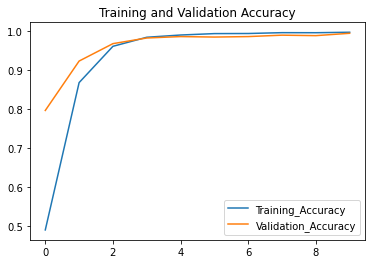

In [24]:
# Plot Accuracy
plt.title('Training and Validation Accuracy')
plt.plot(train_accuracy)
plt.plot(valid_accuracy)
plt.legend(['Training_Accuracy','Validation_Accuracy'])

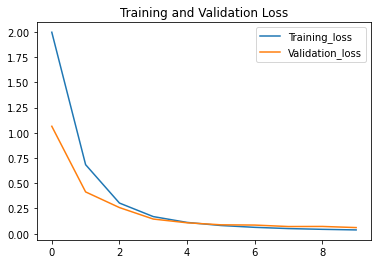

In [25]:
plt.title('Training and Validation Loss')
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(['Training_loss','Validation_loss'])

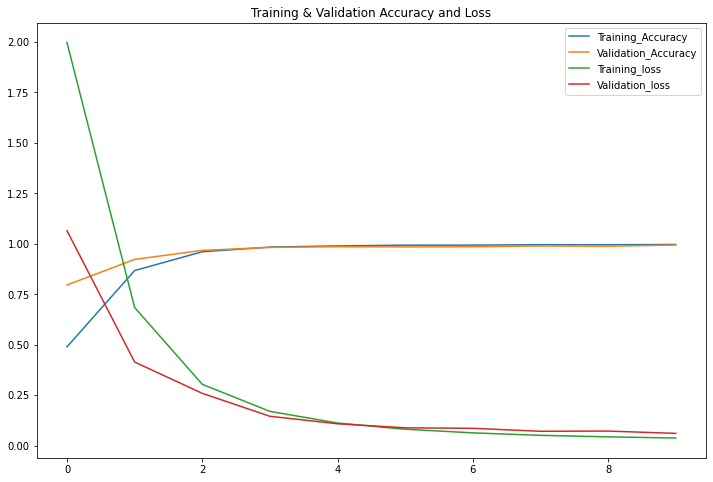

In [26]:
plt.figure(figsize=(12,8))
plt.title('Training & Validation Accuracy and Loss')
plt.plot(train_accuracy)
plt.plot(valid_accuracy)
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(['Training_Accuracy','Validation_Accuracy','Training_loss','Validation_loss'])

## F1 - Score, AUC-ROC, Confusion Matrix

In [27]:
from sklearn.metrics import f1_score, classification_report

with torch.no_grad():
  complete_outputs = []
  complete_labels = []
  for data in dataloaders["valid"]:
    inputs, labels  = data
    inputs = inputs.permute(0,3,1,2)
    inputs = inputs.to(device)
    labels = labels.to(device,dtype=torch.long)
    inputs = Variable(inputs)
    labels = Variable(labels)
    outputs = model(inputs)
    complete_outputs.extend(list(outputs.argmax(1).cpu().data.numpy()))
    complete_labels.extend(list(labels.cpu().data.numpy()))

assert len(complete_outputs) == len(complete_labels)
sk_report = classification_report(y_pred=complete_outputs, y_true=complete_labels)
print(sk_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        64
           1       0.98      1.00      0.99        60
           2       1.00      1.00      1.00        88
           3       1.00      0.95      0.97        19
           4       0.98      0.98      0.98        61
           5       1.00      0.98      0.99        45
           6       1.00      0.98      0.99        62
           7       0.98      1.00      0.99        44
           8       1.00      1.00      1.00        39
           9       1.00      1.00      1.00        31
          10       1.00      1.00      1.00        39
          11       0.96      1.00      0.98        24
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        13
          14       1.00      1.00      1.00        17
          15       1.00      1.00      1.00        41
          16       1.00      1.00      1.00        78
          17       1.00    

# Inference

In [35]:
mapper_dict = {'1':0, '2':1, '3':2, '4':3, '5':4, '6':5, '7':6, '8':7, '9':8, '10':9, 
               '11':10, '12':11, '13':12, '14':13, '15':14, '16':15, '18':16, '19':17, '20':18, '22':19, '23':20}

inference_mapper = {}
for k,v in mapper_dict.items():
  inference_mapper[str(v)] = int(k)



{'0': 1,
 '1': 2,
 '10': 11,
 '11': 12,
 '12': 13,
 '13': 14,
 '14': 15,
 '15': 16,
 '16': 18,
 '17': 19,
 '18': 20,
 '19': 22,
 '2': 3,
 '20': 23,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}


Out of 50 samples, model predicted 49 samples correctly

Legends : Original Label Vs Predicted Label


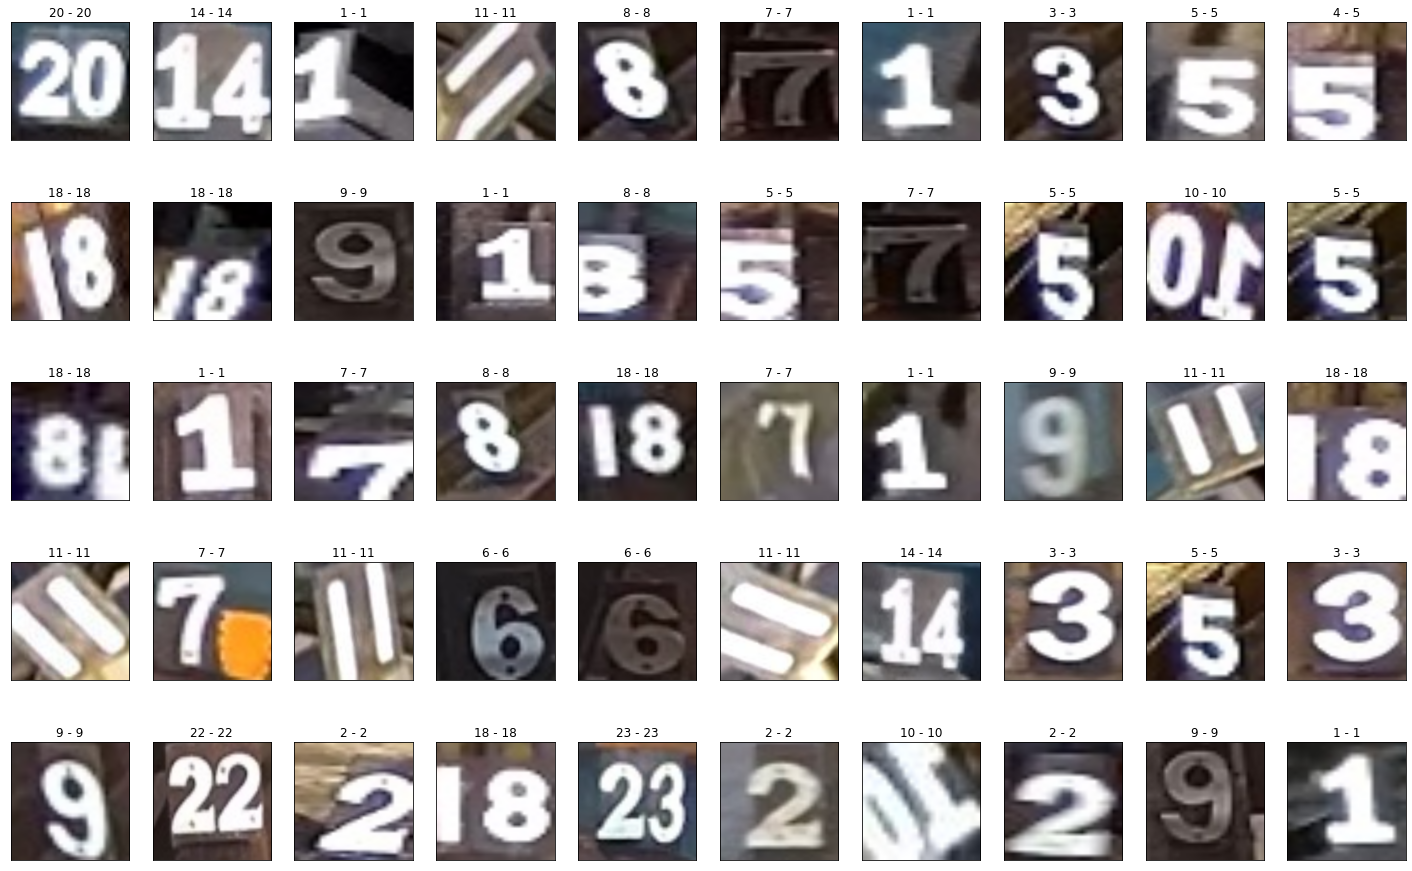

In [37]:
def image_preprocess(file_path, img_size=input_size):
  image = cv2.imread(file_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (img_size, img_size))
  image = image.astype(np.float32)
  image /= 255.
  # print("Shape {} and Type {} and Data-Type {}".format(image.shape, type(image), image.dtype))
  image = np.array(image)
  image = torch.from_numpy(image)
  #plt.imshow(image)
  #plt.show()
  return image
  
def tester(image, model):
    img = (image).to(device)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2) # (bs, width, height, channels) --> (bs, channels, width, height)
    output = model(img)
    return output.argmax(1).item()


NUM_SAMP=10
fig = plt.figure(figsize=(25, 16))
count = 0
for jj in range(5):
    for i, (idx, row) in enumerate(df[df.fold=="valid"].sample(NUM_SAMP,random_state=123+jj).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, jj * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path= row['file_path']
        orig_label = int(row['labels'] )
        image = image_preprocess(path) #224,224,3
        pred_label = tester(image, model)
        if (orig_label == pred_label):
            count +=1
        plt.imshow(image)
        ax.set_title('%d - %d' % (inference_mapper[str(orig_label)], inference_mapper[str(pred_label)]))
print()
print("Out of {} samples, model predicted {} samples correctly".format((NUM_SAMP*5), count))
print()
print("Legends : Original Label Vs Predicted Label")

# The End

In [29]:
def process_image(image_array, majority=False, debug=True):
  image = cv2.imread(image_array)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  image = cv2.resize(image, (224, 224))
  image = image.astype(np.float32)
  image = np.array(image)
  if debug:
    cv2_imshow(image)
  image /= 255.
  image = torch.from_numpy(image)
  image = image.to('cuda:0')
  image = image.unsqueeze(0)
  image = image.permute(0,3,1,2) #torch.Size([1, 3, 224, 224])
  return image
numbers2text = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
                      10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'J',
                      19: 'K', 20: 'L', 21: 'M', 22: 'N', 23: 'O', 24: 'P', 25: 'Q', 26: 'R', 27: 'S',
                      28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 33: 'Y', 34: 'Z'}

for i in os.listdir('/content/test_data'):
  sample_input = process_image(os.path.join('/content/test_data', i))
  out = model(sample_input)
  print(numbers2text[out.argmax(1).item()])

FileNotFoundError: ignored

In [ ]:
sample_input.max()